In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset from previous step
df = pd.read_csv("../../data/processed/train_dataset_formatted_no_missing.csv")
df.head()

,longitude,latitude,source,gravity_iso_residual,gravity_cscba,gravity_cscba_1vd,mag_uc_1_2km,mag_uc_2_4km,mag_uc_4_8km,mag_uc_8_12km,mag_uc_12_16km,radio_k_pct,radio_th_ppm,radio_u_ppm,radio_th_k_ratio,radio_u_k_ratio,radio_u_th_ratio,label
0,134.324653,-27.294063,blank_area,-204.018005,-426.38882,-309.04285,-19.665098,-33.036575,-46.971394,-30.871347,-21.795435,0.759041,9.374757,1.196567,12.357069,1.577670,0.127658,0
1,148.050504,-32.937903,positive,93.298981,-186.38301,-2674.96260,-44.330212,23.895699,107.432144,82.715973,57.587337,1.154886,8.526972,1.396929,7.434864,1.215049,0.163990,1
2,119.027100,-22.975700,other_deposit,-200.687836,-739.63226,-1203.50880,-442.748383,-354.920288,-211.401382,-84.787079,-53.003239,0.126347,3.217272,0.572410,16.086359,2.862052,0.178862,0
3,121.464232,-23.649192,blank_area,-163.918274,-592.99493,-536.70370,18.632324,31.867907,50.295372,35.592964,25.073792,0.184210,3.271043,0.369300,16.355215,1.846498,0.113002,0
4,142.469900,-35.168600,other_deposit,-81.172989,-139.28423,-507.28357,-0.266748,-0.374094,-0.820666,-0.999457,-1.124462,0.413259,4.779623,0.953914,11.560739,2.311097,0.200272,0


## 1. Identify Skewed Features with Potential Outliers

In [3]:
# Calculate skewness for each feature
skewed = df.drop(columns=['label', 'source', 'longitude', 'latitude']).skew().sort_values(ascending=False)

# Display most skewed features
skewed_features = skewed[abs(skewed) > 1]
print("Skewed features (|skew| > 1):")
display(skewed_features)

Skewed features (|skew| > 1):


radio_u_th_ratio    16.362744
mag_uc_1_2km        14.917434
mag_uc_2_4km         9.548136
radio_th_ppm         9.287075
radio_th_k_ratio     8.696902
radio_u_ppm          8.075040
mag_uc_4_8km         5.943830
radio_u_k_ratio      5.674984
mag_uc_8_12km        2.685601
radio_k_pct          1.384089
mag_uc_12_16km       1.358330
dtype: float64

Several features in the dataset exhibit strong right-skewed distributions and extreme values (e.g., `radio_Th_K_ratio`, `radio_U_K_ratio`, `gravity_cscba_1vd`). To mitigate their influence on model performance:

We applied **log1p transformation** to reduce skewness while retaining continuous variation. Optionally, we **clipped** values above the 99th percentile to limit extreme impact (especially in radiometric ratios). Transformed versions of these features are retained as new columns (`*_log` or `*_clipped`) for further selection and modeling.

From a geoscience perspective, applying log1p to skewed geochemical features such as radiometric element concentrations or derived ratios is both scientifically sound and statistically effective. These features often follow log-normal distributions due to natural enrichment processes, and log-transformation helps stabilize variance and reduce the influence of outliers.

However, for physical-field-based features (e.g., gravity or magnetics), log-transformation should be used cautiously, as these features may contain negative values and hold directional/geophysical meaning. In such cases, alternative normalization techniques (e.g., robust scaling or clipping) may be more appropriate.

## 2. Log Transfomation and Clipping

In [13]:
# Apply log1p transformation to radiometric / geochemical features
log1p_cols = [
    'radio_u_th_ratio', 'radio_th_ppm', 'radio_th_k_ratio',
    'radio_u_ppm', 'radio_u_k_ratio', 'radio_k_pct'
]

for col in log1p_cols:
    df[col + '_log'] = np.log1p(df[col].clip(lower=0).fillna(0))

print("log1p transformation applied to geochemical features.")

# Clip extreme magnetic values (99th percentile)
clip_mag_cols = [
    'mag_uc_1_2km', 'mag_uc_2_4km', 'mag_uc_4_8km',
    'mag_uc_8_12km', 'mag_uc_12_16km'
]

for col in clip_mag_cols:
    upper = df[col].quantile(0.99)
    lower = df[col].quantile(0.01)
    df[f"{col}_clipped"] = df[col].clip(lower=lower, upper=upper)

print("Magnetic features clipped at [1%, 99%] to reduce extreme outliers.")


log1p transformation applied to geochemical features.
Magnetic features clipped at [1%, 99%] to reduce extreme outliers.


In [14]:
df.head()

,longitude,latitude,source,gravity_iso_residual,gravity_cscba,gravity_cscba_1vd,mag_uc_1_2km,mag_uc_2_4km,mag_uc_4_8km,mag_uc_8_12km,...,radio_th_ppm_log,radio_th_k_ratio_log,radio_u_ppm_log,radio_u_k_ratio_log,radio_k_pct_log,mag_uc_1_2km_clipped,mag_uc_2_4km_clipped,mag_uc_4_8km_clipped,mag_uc_8_12km_clipped,mag_uc_12_16km_clipped
0,134.324653,-27.294063,blank_area,-204.018005,-426.38882,-309.04285,-19.665098,-33.036575,-46.971394,-30.871347,...,2.339376,2.592046,0.786896,0.946886,0.564769,-19.665098,-33.036575,-46.971394,-30.871347,-21.795435
1,148.050504,-32.937903,positive,93.298981,-186.38301,-2674.96260,-44.330212,23.895699,107.432144,82.715973,...,2.254127,2.132374,0.874188,0.795274,0.767738,-44.330212,23.895699,107.432144,82.715973,57.587337
2,119.027100,-22.975700,other_deposit,-200.687836,-739.63226,-1203.50880,-442.748383,-354.920288,-211.401382,-84.787079,...,1.439188,2.838280,0.452610,1.351199,0.118980,-211.120219,-161.594283,-139.436635,-71.818292,-49.249933
3,121.464232,-23.649192,blank_area,-163.918274,-592.99493,-536.70370,18.632324,31.867907,50.295372,35.592964,...,1.451858,2.853893,0.314299,1.046089,0.169076,18.632324,31.867907,50.295372,35.592964,25.073792
4,142.469900,-35.168600,other_deposit,-81.172989,-139.28423,-507.28357,-0.266748,-0.374094,-0.820666,-0.999457,...,1.754338,2.530576,0.669835,1.197280,0.345898,-0.266748,-0.374094,-0.820666,-0.999457,-1.124462


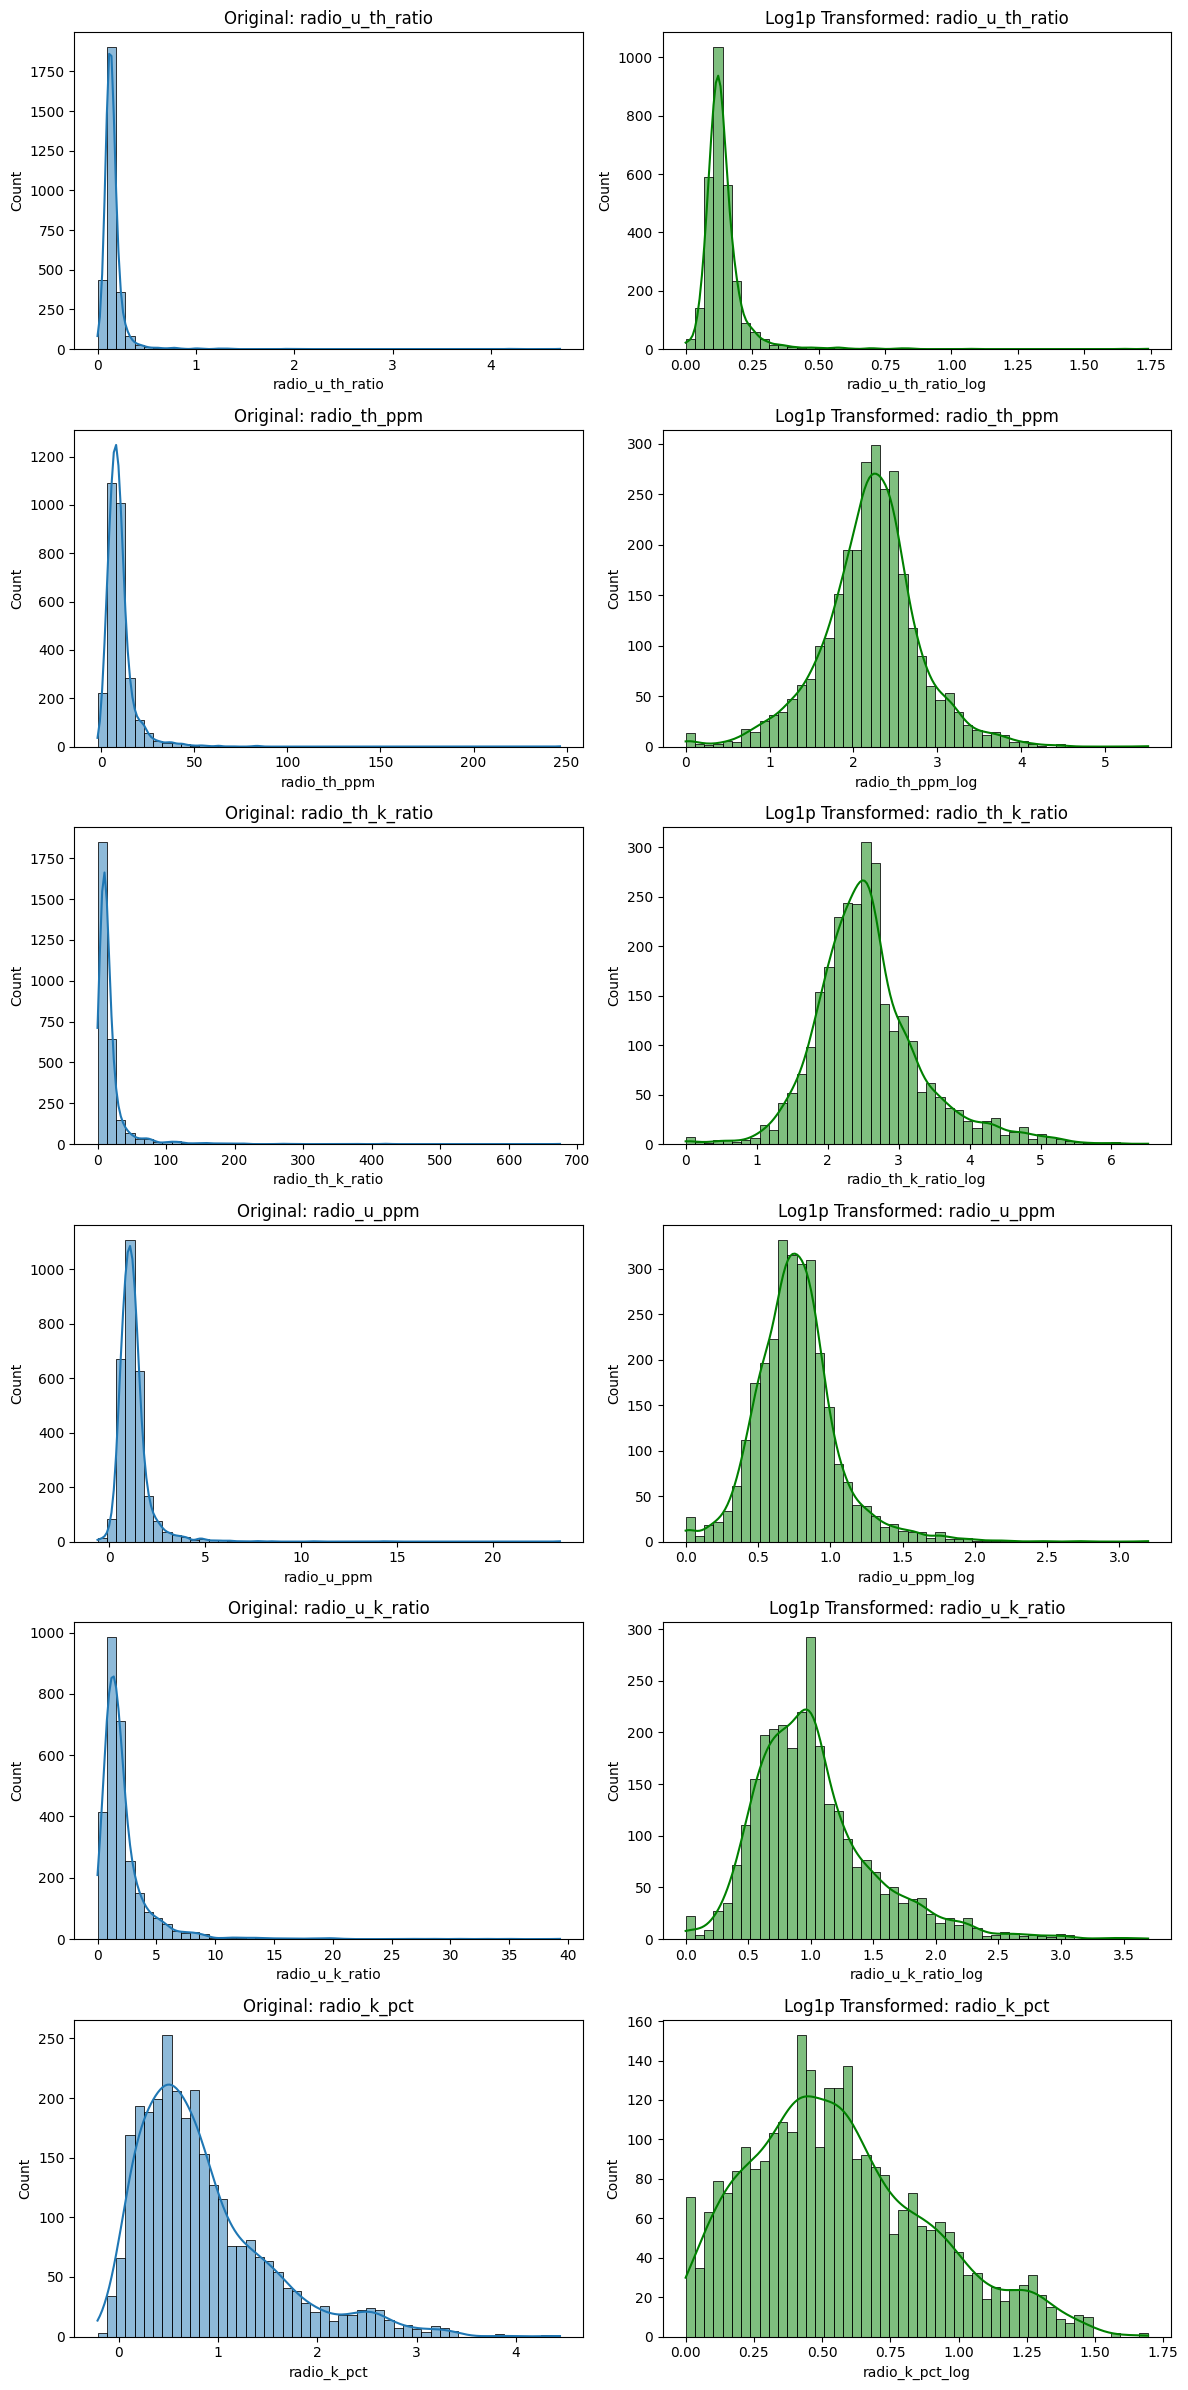

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(len(log1p_cols), 2, figsize=(12, 4 * len(log1p_cols)))

# Visualizing log transform effect
for i, col in enumerate(log1p_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i][0])
    axes[i][0].set_title(f"Original: {col}")
    
    sns.histplot(df[f"{col}_log"], bins=50, kde=True, ax=axes[i][1], color="green")
    axes[i][1].set_title(f"Log1p Transformed: {col}")
    
plt.tight_layout()
plt.show()


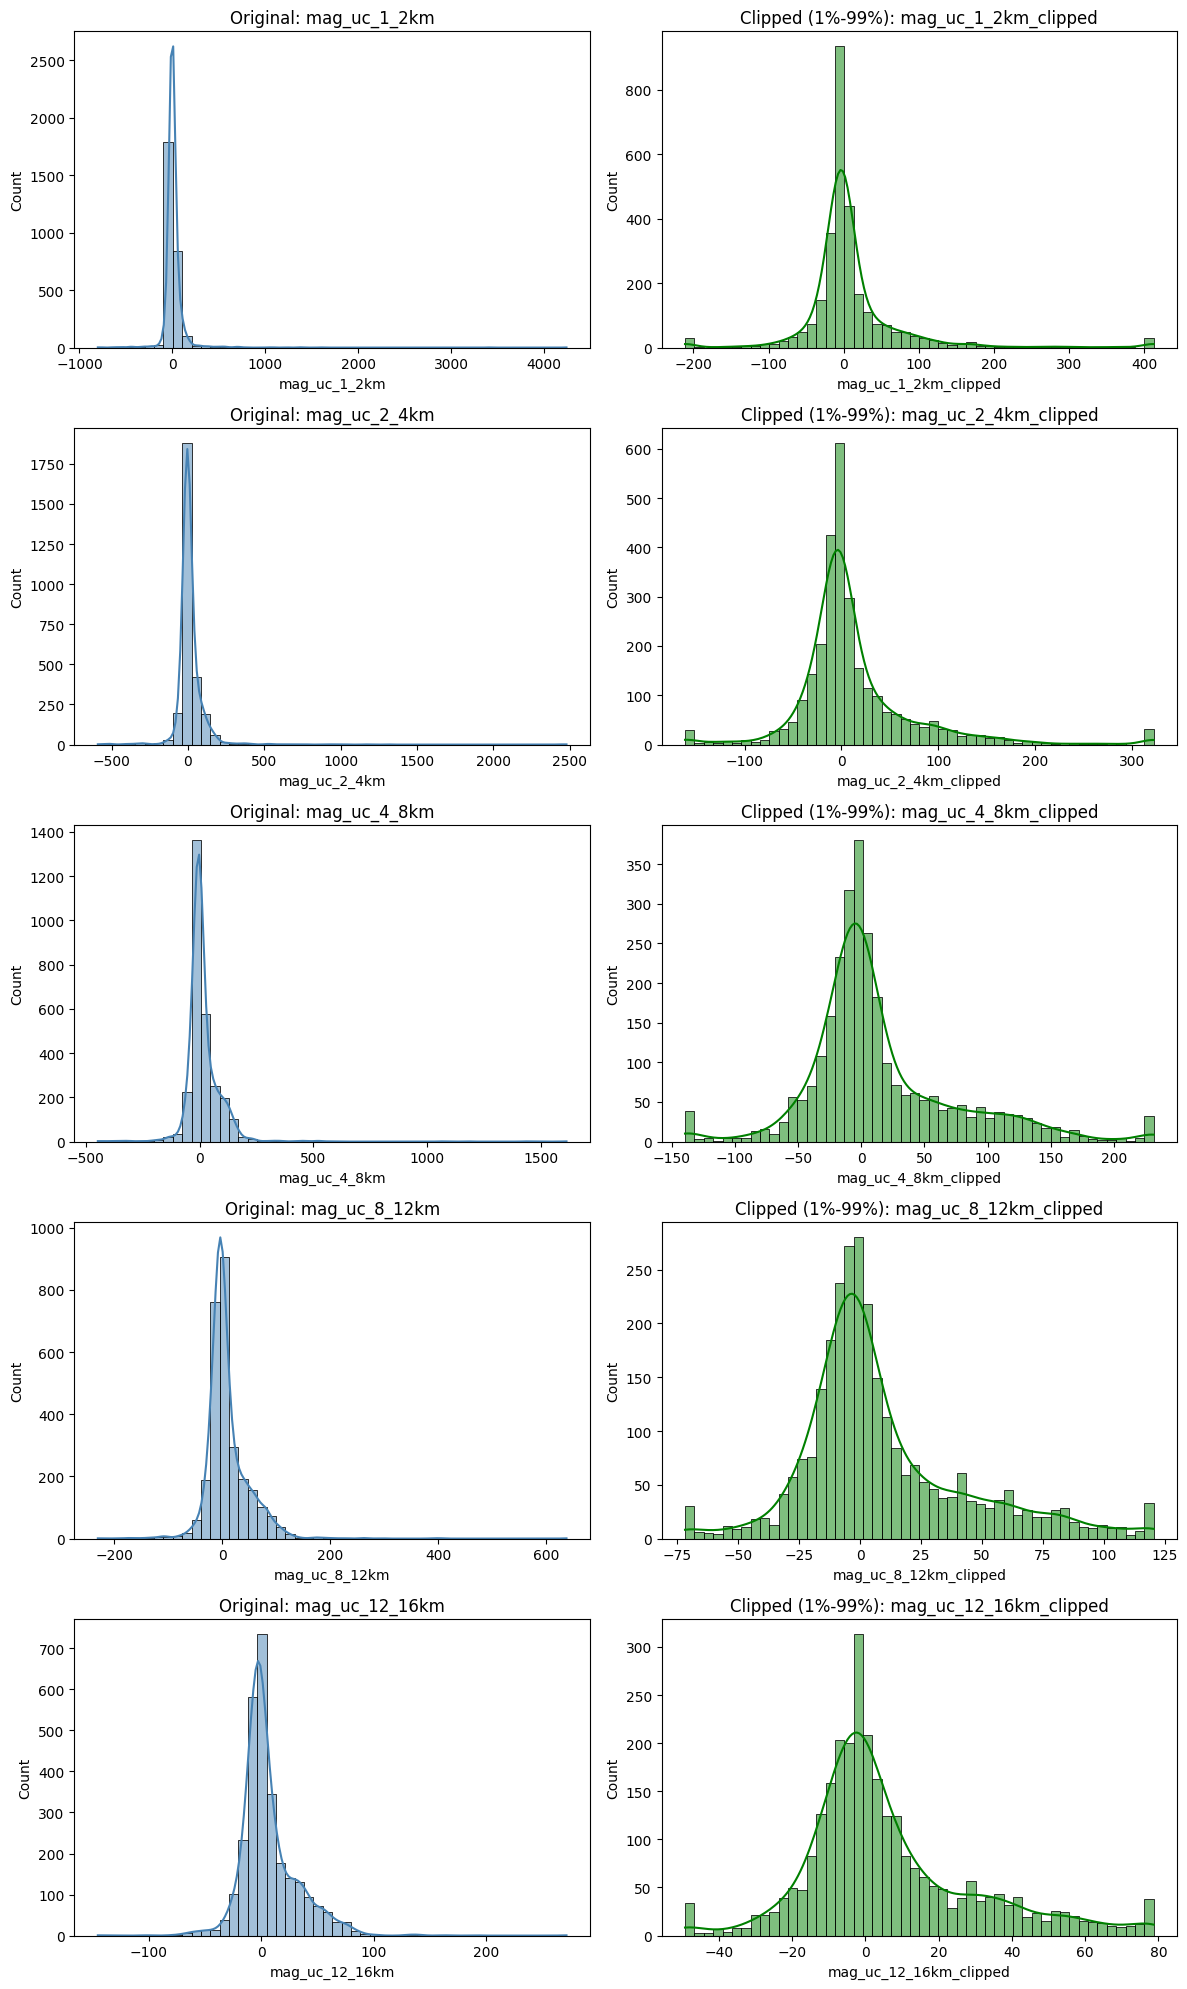

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of clipped magnetic features
clip_mag_cols = [
    'mag_uc_1_2km', 'mag_uc_2_4km', 'mag_uc_4_8km',
    'mag_uc_8_12km', 'mag_uc_12_16km'
]

# Plot before vs after clipping
fig, axes = plt.subplots(len(clip_mag_cols), 2, figsize=(12, 4 * len(clip_mag_cols)))

for i, col in enumerate(clip_mag_cols):
    # Original distribution
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i][0], color='steelblue')
    axes[i][0].set_title(f"Original: {col}")
    
    # Clipped distribution
    clipped_col = col + "_clipped"
    sns.histplot(df[clipped_col], bins=50, kde=True, ax=axes[i][1], color='green')
    axes[i][1].set_title(f"Clipped (1%-99%): {clipped_col}")

plt.tight_layout()
plt.show()


In mineral prospectivity modeling, extreme values often represent true mineralized signatures rather than noise. Removing them may eliminate critical signal patterns, especially for rare positive-class samples (e.g., porphyry copper deposits).

Therefore, instead of deleting outliers, we apply robust transformations (log1p, clipping) to reduce their modeling influence while preserving their geological meaning. Positive-class outliers are treated with special caution and retained in full.

In [6]:
# set the features to check
features_to_check = ['mag_uc_1_2km', 'mag_uc_2_4km', 'mag_uc_4_8km', 'mag_uc_8_12km', 'mag_uc_12_16km']

# store the results
clipped_positive_counts = {}

for feature in features_to_check:
    upper = df[feature].quantile(0.99)
    lower = df[feature].quantile(0.01)

    # find clipped positives
    clipped_positives = df[
        (df['label'] == 1) &
        ((df[feature] > upper) | (df[feature] < lower))
    ]

    clipped_positive_counts[feature] = {
        "total_positive": (df['label'] == 1).sum(),
        "clipped_positive_count": len(clipped_positives),
        "clipped_positive_percent": round(len(clipped_positives) / (df['label'] == 1).sum() * 100, 2)
    }

# show results
import pandas as pd
pd.DataFrame(clipped_positive_counts).T



,total_positive,clipped_positive_count,clipped_positive_percent
mag_uc_1_2km,950.0,0.0,0.00
mag_uc_2_4km,950.0,0.0,0.00
mag_uc_4_8km,950.0,2.0,0.21
mag_uc_8_12km,950.0,5.0,0.53
mag_uc_12_16km,950.0,9.0,0.95


### Clipping Impact on Positive-Class Samples (label = 1)

We examined the effect of [1%, 99%] percentile clipping on five upward-continued magnetic features (`mag_uc_*`). The goal was to ensure that extreme values from **positive-class samples** (porphyry copper deposits) are not unintentionally removed, as these may contain geophysically meaningful signals.

The results are as follows:

| Feature           | Total Positive Samples | Clipped Positives | Percentage Affected |
|------------------|------------------------|-------------------|----------------------|
| mag_uc_1_2km      | 950                    | 0                 | 0.00%                |
| mag_uc_2_4km      | 950                    | 0                 | 0.00%                |
| mag_uc_4_8km      | 950                    | 2                 | 0.21%                |
| mag_uc_8_12km     | 950                    | 5                 | 0.53%                |
| mag_uc_12_16km    | 950                    | 9                 | 0.95%                |

**Interpretation**:
- All five features have extremely low proportions (<1%) of positive samples that would be clipped.
- This validates that the clipping strategy is **safe and minimally invasive** for target signals.
- No further adjustment is needed for these features — they can be confidently used in downstream modeling.

**Conclusion**: The outlier handling method preserves critical patterns in the positive class and balances statistical regularization with domain fidelity.

In [7]:
df.to_csv("../../data/processed/train_dataset_formatted_no_missing_transformed.csv", index=False)
print("Saved to: train_dataset_formatted_no_missing_transformed.csv")

Saved to: train_dataset_formatted_no_missing_transformed.csv


## 3. Outlier Handling Summary

Several features in the dataset exhibit strong right-skewed distributions and extreme values (e.g., `radio_Th_K_ratio`, `radio_U_K_ratio`, `mag_uc_*`). To mitigate their influence on model performance:

- We applied **log1p transformation** to reduce skewness while retaining continuous variation.
- Optionally, we **clipped** values above the 99th percentile to limit extreme impact.
- Transformed versions of these features are retained as new columns (`*_log` or `*_clipped`) for further selection and modeling.